# FINAL PROJECT (PART 4) - MODELING PERFORMANCE (Ellein Cheng)

## 1) Problem Statement

Human trafficking occurs in every country in the world, including the U.S. Between 27 and 45.8 million individuals worldwide are trapped in some form of modern-day slavery. The victims are forced into slavery as sex workers, beggars and child soldiers, or as domestic workers, factory workers and laborers in manufacturing, construction, mining, commercial fishing and other industries. It has sadly become a hugely profitable industry, generating an estimated US$150 billion annually in illegal profits per year. 

Analytics could help law enforcement combat human trafficking.  Traffickers often leave a data trail as they move the "supply" (human victim) through a network to meet "demand (for cheap, vulnerable and illegal labor), despite their efforts to operate off the grid and in the shadows. With such data, there is an opportunity to use bits and pieces of information gathered to get on the distribution of victims, traffickers and exploiters, and to disrupt the supply chain wherever and however possible.  

This is where data science comes in.  For this particular project, the objective is to perform some predictive modeling based on demographic data of trafficked victims, against output variable such as exploitation location, type of exploitation (e.g. Sexual/Labor), types of labor, and means of control traffickers used to manipulate the victims.

## 2) The data:

The dataset for this project is aquired from Counter-Trafficking Data Collaborative, who serves as a central repository for critical information about human trafficking. It publishes standard and harmonized data from various organizations using a unified schema in its Global Dataset, which includes data from 2002 to 2017.  Data contributors include the International Organization for Migration, Polaris, and Liberty Asia.  The Global Dataset currently has about 47,000 data points across 62 variables that could be grouped as follows:
- Demographics 
- Exploitation Geo
- Types of Exploitation
- Means of Control
- Types of Labour 
- Types of Sexual Exploitation
- Is Abduction?
- Recruiter Relations

## 3) Data Cleaning

One of the biggest challenge with this project is that the dataset has a lot of missing values.  Starting with a dataset of about 47,000 rows, I have taken the following steps to tackle missing values:
- Remove all rows with unknown gender
- Consolidate all columns related to Majority Status
- Modify age range category into a number by using the mean
- Impute missing ages with averages by majority status (one average for Adult, one average for Minor)
- Due to difference in data sources, geo unknowns are denoted in different ways.  Change citizenship and country of exploitation value -99 to ZZ.
- For each groups of variables, remove rows where none of the columns are 1, and replace all remaining -99's with zeros.  Since much of these data are collected from hotline statistics, it's likely that if there's indication of at least one column being 1, it's a reasonable assumption to say the other columns are 0s.  If all columns are 0, then the "Not Specified" column for that group of variables is set as 1.
- There are some inconsistencies in the data as well: e.g. at least one type of Sexual Exploitation is indicated as 1, but the isSexualExploit column is still 0. In those cases, I corrected those specific isSexualExploit=0 to 1.
- Drop columns that are redundant with other columns or are totally not reliable (e.g. isAbduction)
- For geo data, in order to decrease the dimension of the data, I bucketed the countries into regions around the globe that are less granular than countries, but more granular than continents

Remaining number of data points: about 18,000
This data is further carved out according to what output variables we are exploring and whether more bad data needs to be removed.


## 4) Exploratory Analysis

### a) Plotting Year Counts

First I explored the year counts of the data and see that there is a huge spikes in data availability from 2014 to 2016 as shown in the graph below.  This could imply some potential sample biases and is also the reason why I have not taken Year Of Registration in account when deciding on input variables.

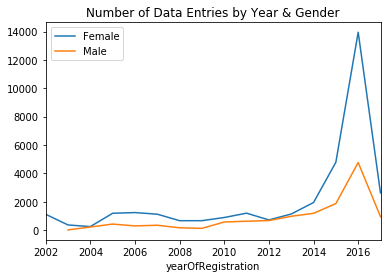

In [3]:
# Import Raw Global Dataset and Plot year counts
import pandas as pd  
GD_data_raw = pd.read_csv('assets/TheGlobalDataset27Nov2017_0.csv')

#Female Data
GD_data_raw_F = GD_data_raw[GD_data_raw.gender == 'Female']
GD_data_raw_F_count = GD_data_raw_F.groupby(['yearOfRegistration']).size()
#Male Data
GD_data_raw_M = GD_data_raw[GD_data_raw.gender == 'Male']
GD_data_raw_M_count = GD_data_raw_M.groupby(['yearOfRegistration']).size()
# Visualize counts by Gender
from matplotlib import pyplot as plt  
GD_data_raw_F_count.plot.line(x='yearOfRegistration',y='count')
GD_data_raw_M_count.plot.line(x='yearOfRegistration',y='count')
plt.title("Number of Data Entries by Year & Gender")
plt.legend(['Female','Male'])
plt.show()

### b) Visualization of categorical data:

In [72]:
#Read Cleaned Global Data
GD_data_final = pd.read_csv('assets/GD_data_final.csv')

In [19]:
import numpy as np
import matplotlib as mpl
import seaborn as sns
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))

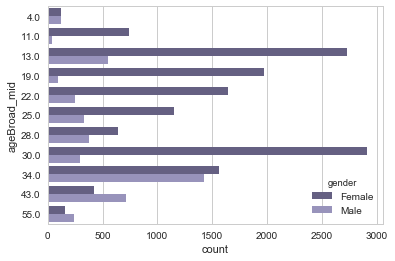

In [96]:
### GENDER & AGE
### Hue counts - by gender in each age group
sns.countplot(y="ageBroad_mid", hue="gender", data=GD_data_final, palette="Purples_d");

C:\Users\ellei\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


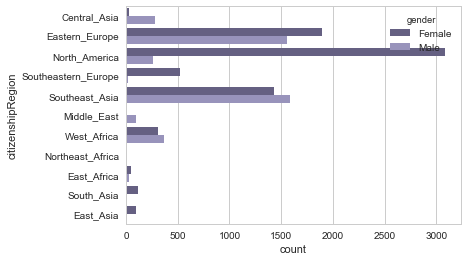

In [50]:
### CITIZENSHIP GEO & EXPLOITATION GEO
### Disregard Unknown Geo data
GD_data_knownGeo = GD_data_final[(GD_data_final['citizenshipRegion']!='Unknown')][(GD_data_final['exploitationRegion']!='Unknown')]
### Hue counts - by gender in citizenship
sns.countplot(y="citizenshipRegion", hue="gender", data=GD_data_knownGeo, palette="Purples_d");

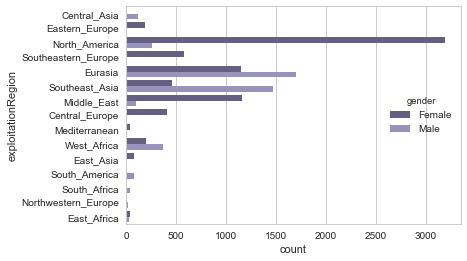

In [94]:
### Hue counts - by gender in exploitation geo
sns.countplot(y="exploitationRegion", hue="gender", data=GD_data_knownGeo, palette="Purples_d");

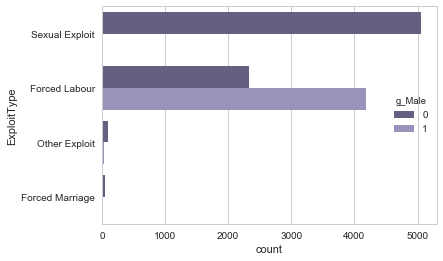

In [95]:
### GENDER VS TYPES OF EXPLOITATION
### Since Exploitation Type are not comletely mutually exclusive (i.e. One can be both isSexualExploit and isForcedLabour, 
### and thus isSexAndLabour), change those rows to just 1 for isSexAndLabour - nothing else
# Read Demographic vs Exploitation Geo Data
demo_exptype_knowngeo = pd.read_csv('assets/demo_exptype_knowngeo.csv')

def nullify_Sex(x):
    if x['isSexAndLabour'] == 1:
        return 0
    else:
        return x['isSexualExploit']
def nullify_Labor(x):
    if x['isSexAndLabour'] == 1:
        return 0
    else:
        return x['isForcedLabour']
demo_exptype_calc['isSexualExploit'] = demo_exptype_knowngeo.apply(nullify_Sex,axis=1)
demo_exptype_calc['isForcedLabour'] = demo_exptype_knowngeo.apply(nullify_Labor,axis=1)

### Consolidate all types of exploitation into one column
def combine_expType(x):
    if x['isForcedLabour'] == 1:
        return 'Forced Labour'
    elif x['isSexualExploit'] == 1:
        return 'Sexual Exploit'
    elif x['isOtherExploit'] == 1:
        return 'Other Exploit'
    elif x['isSexAndLabour'] == 1:
        return 'Sex and Labour'
    elif x['isForcedMarriage'] == 1:
        return 'Forced Marriage'
    elif x['isForcedMilitary'] == 1:
        return 'Forced Military'
    elif x['isOrganRemoval'] == 1:
        return 'Organ Removal'
    else:
        return 0
        
demo_exptype_knowngeo['ExploitType'] = demo_exptype_knowngeo.apply(combine_expType,axis=1)

### Hue counts - by gender in exploitation geo
sns.countplot(y='ExploitType', hue="g_Male", data=demo_exptype_knowngeo, palette="Purples_d");

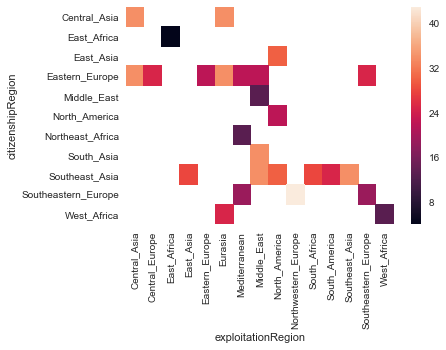

In [56]:
# Exploring Citizenship vs Exploitation - median age
df = GD_data_knownGeo.pivot_table(index='citizenshipRegion', columns='exploitationRegion', values='ageBroad_mid', aggfunc=np.median)
sns.heatmap(df, annot=False, fmt=".1f")

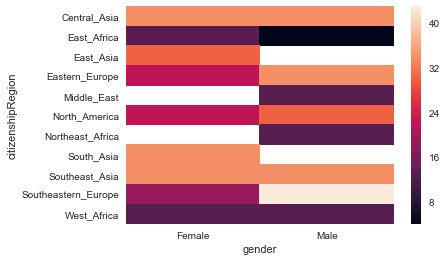

In [58]:
# Exploring Citizenship vs gender - median age
df = GD_data_knownGeo.pivot_table(index='citizenshipRegion', columns='gender', values='ageBroad_mid', aggfunc=np.median)
sns.heatmap(df, annot=False, fmt=".1f")

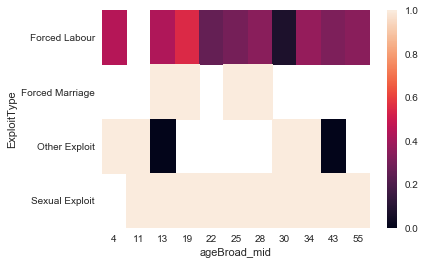

In [68]:
# Exploring gender, Exploit type, Age
df = demo_exptype_knowngeo.pivot_table(index='ExploitType', columns='ageBroad_mid', values='g_Female', aggfunc=np.mean)
sns.heatmap(df, annot=False, fmt=".1f")

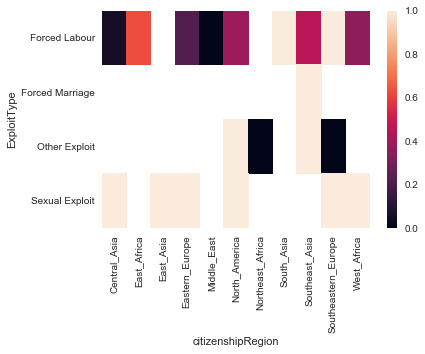

In [69]:
# Exploring Exploit Type, Citizenship, Gender
df = demo_exptype_knowngeo.pivot_table(index='ExploitType', columns='citizenshipRegion', values='g_Female', aggfunc=np.mean)
sns.heatmap(df, annot=False, fmt=".1f")

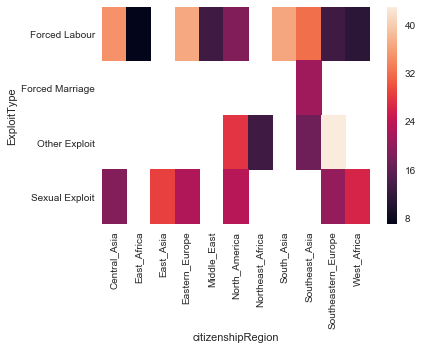

In [71]:
# Exploring Exploit Type, Exploitation Geo, Gender
df = demo_exptype_knowngeo.pivot_table(index='ExploitType', columns='citizenshipRegion', values='ageBroad_mid', aggfunc=np.mean)
sns.heatmap(df, annot=False, fmt=".1f")

### c) Correlation

I created dummy columns for the categorical variables and computed the correlation matrices exploring the associations between the demographic data vs different groups of output variables: i) Exploitation Region, ii) Means of Control, iii) Type of Exploitation, iv) Type of Labor, v) Type of Sexual Exploitation

##### Eg.: Type of Exploitation Data

   | Forced Labor | 
   --- | --- |
   Male | 0.7 |    
Southeast Asia | 0.56
Asia | 0.59 |

   | Sexual Exploit |
   --- | --- |
   Female | 0.66 |

##### Eg.: Means of Control Data (Generally not very strong)

   | Takes Earnings | False Promises | Restricts Medical Care | Excessive Working Hours | Withhold Necessities |
   --- | --- | --- | --- | --- | --- |
   Age | 0.28 | 0.27 | 0.26 | 0.33 | 0.16 |
   Male | 0.26 | 0.32 | 0.23 | 0.35 | 0.17 |
   Citizenship Central Asia | 0.26 | 0.24 | 0.29 | 0.18 | 0.34 |
   Citizenship Eastern Europe | 0.20 | 0.25 | 0.22 | 0.31 | 0.02 |

##### Eg.: Types of Labor

 | Agriculture | Begging | Construction | Domestic Work 
 --- | --- | --- | --- | --- 
 Citizenship North America | 0.33 |  |  | 0.21 
 Citizenship East Africa |  | 0.68 |  |  |
 Male |  |  | 0.32 | 
 Female |  |  |  | 0.26 | 
 Citizenship Easter Europe |  |  | 0.52 | 
 South Asia |  |  |  | 0.40 |
 
 



## 5) Modeling

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score,train_test_split
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import random
import pdb

C:\Users\ellei\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The question I would like to explore through this project is "How does Demographic Data predict Human Trafficking Patterns?"
To do so, I performed separate models for different output variables.  For certain output variables, I also added Recruiter Relations as additional features.  However, generally speaking, Recruiter Relations is not a strong predictor of any of the outcomes mostly due to there being a lot of "Not Specified" relations, leading to biases in the results.

The models that I have employed for this project include:
- Multinomial Logistic Regression
- Random Forest
- One-vs-Rest

When modeling, I tested out feeding in different combinations of features and most of the time, including more Demographic features yield higher accuracy scores.  One thing I had to be mindful of when dealing with dummy variables is to avoid multicollinearity by pulling one of the column out from the features.  For example, I have encoded two columns for gender, one for Female and one for Male.  I only need to feed in one of these two columns as a feature because if Female=0, then it automatically implies Male.  

### a) Predicting Exploitation Region with Demographic Data

#### i) Multinomial Logistic Regression

In [89]:
# Read Demographic vs Exploitation Geo Data
demo_expgeo_calc = pd.read_csv('assets/demo_expgeo_calc.csv')
demo_expgeo_calc2 = demo_expgeo_calc.iloc[:,:25].join(GD_data_final[['exploitationRegion','exploitationGeoCategory']])
demo_expgeo_calc2.columns
demo_expgeo_headers = ['ageBroad_mid', 'g_Female', 'ms_Adult', 
                          'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                          'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                          'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa', 
                          'exploitationRegion']

### Train Test Split 
X = demo_expgeo_calc2[demo_expgeo_headers[:-1]]
y = demo_expgeo_calc2[demo_expgeo_headers[-1]]
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7)

# Train multinomial logistic regression model
mul_lr = LogisticRegression(multi_class='multinomial', solver='newton-cg')
mul_lr.fit(train_x, train_y)

print "Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(train_y, mul_lr.predict(train_x))
print "Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, mul_lr.predict(test_x))

print ("Cross validating...")
print ("Multinomial Log Reg - train accuracy: ")
print (np.mean(cross_val_score(mul_lr, train_x, train_y.values, scoring='accuracy', cv=10)))

print ("Classes: ")
print (mul_lr.classes_)
pred_y = mul_lr.predict(test_x)

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

## to use, first generate confusion matrix:
print ("Confusion Matrix: ")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, pred_y)
target = ['Central_Asia', 'Central_Europe', 'East_Africa', 'East_Asia', 'Eastern_Europe',
 'Eurasia', 'Mediterranean', 'Middle_East', 'North_America',
 'Northwestern_Europe', 'South_Africa', 'South_America', 'Southeast_Asia',
 'Southeastern_Europe', 'Unknown', 'West_Africa']
## then convert to pandas DataFrame:
cm_as_df=cm2df(cm,target)


Multinomial Logistic regression Train Accuracy ::  0.883134951306
Multinomial Logistic regression Test Accuracy ::  0.873782906599
Cross validating...
Multinomial Log Reg - train accuracy: 
0.883138419693
Classes: 
['Central_Asia' 'Central_Europe' 'East_Africa' 'East_Asia' 'Eastern_Europe'
 'Eurasia' 'Mediterranean' 'Middle_East' 'North_America'
 'Northwestern_Europe' 'South_Africa' 'South_America' 'Southeast_Asia'
 'Southeastern_Europe' 'Unknown' 'West_Africa']
Confusion Matrix: 


In [104]:
cm_as_df.to_csv('cm_as_df.csv', index=True)

In [90]:
cm_as_df

,Central_Asia,Central_Europe,East_Africa,East_Asia,Eastern_Europe,Eurasia,Mediterranean,Middle_East,North_America,Northwestern_Europe,South_Africa,South_America,Southeast_Asia,Southeastern_Europe,Unknown,West_Africa
Central_Asia,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0
Central_Europe,0,0,0,0,0,145,0,0,0,0,0,0,0,0,0,0
East_Africa,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0
East_Asia,0,0,0,0,0,0,0,18,0,0,0,0,9,0,0,0
Eastern_Europe,0,0,0,0,0,55,0,0,0,0,0,0,0,0,0,0
Eurasia,0,0,0,0,0,838,0,0,0,0,0,0,0,0,0,0
Mediterranean,0,0,0,0,0,4,4,0,0,0,0,0,0,12,0,0
Middle_East,0,0,0,0,0,61,0,318,0,0,0,0,10,0,0,0
North_America,0,0,0,0,0,0,0,1,2857,0,0,0,0,0,0,0
Northwestern_Europe,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0


##### Interpretation:
Region | Recall | Precision
--- | --- | ---
Central Asia | 0% | 0%
Central Europe | 0% | 0%
East Africa | 100% | 100%
East Asia | 0% | 0%
Eastern Europe | 0% | 0%
Eurasia | 100% | 61%
Meditarranean | 20% | 100%
Middle East | 82% | 81%
North America | 99% | 99% 
Northwestern Europe | 100% | 100%
South Africa | 0% | 0%
South America | 0% | 0%
Southeast Asia | 88% | 90%
Southeastern Europe | 81% | 92% 
West Africa | 100% | 100%


- Best: Northwestern Europe, North America, West Africa, East Africa
- Moderate: Eurasia, Middle East, Southeast Asia, Southeastern Europe
- Worst: Central Asia, Central Europe, East Asia, Eastern Europe, South Africa, South America

#### ii) Random Forest

Random Forest Train Accuracy ::  0.886767661153
Random Forest Logistic regression Test Accuracy ::  0.886765236206
Cross validating...
Random Forest - train accuracy: 
0.885299145901
X: 
Index([u'ageBroad_mid', u'g_Female', u'cr_Central_Asia', u'cr_East_Africa',
       u'cr_East_Asia', u'cr_Eastern_Europe', u'cr_Middle_East',
       u'cr_North_America', u'cr_Northeast_Africa', u'cr_South_America',
       u'cr_South_Asia', u'cr_Southeast_Asia', u'cr_Southeastern_Europe',
       u'cr_West_Africa'],
      dtype='object')
Feature Importance: 
[ 0.131  0.136  0.02   0.011  0.     0.256  0.012  0.045  0.002  0.008
  0.015  0.207  0.08   0.077]


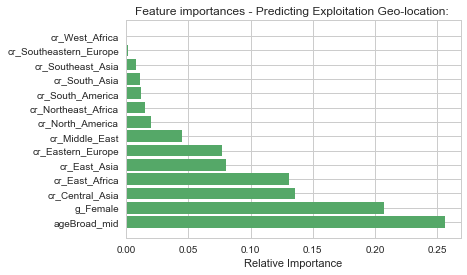

Classes: 
['Central_Asia' 'Central_Europe' 'East_Africa' 'East_Asia' 'Eastern_Europe'
 'Eurasia' 'Mediterranean' 'Middle_East' 'North_America'
 'Northwestern_Europe' 'South_Africa' 'South_America' 'Southeast_Asia'
 'Southeastern_Europe' 'Unknown' 'West_Africa']
Average Probabilities by gender: 
        pp_Central_Asia  pp_Central_Europe  pp_East_Africa  pp_East_Asia  \
gender                                                                     
Female         0.000925           0.029027        0.003131      0.006647   
Male           0.026711           0.003948        0.005869      0.000000   

        pp_Eastern_Europe  pp_Eurasia  pp_Mediterranean  pp_Middle_East  \
gender                                                                    
Female           0.013356    0.081855          0.003387        0.081087   
Male             0.000000    0.383111          0.002935        0.022122   

        pp_North_America  pp_Northwestern_Europe  pp_South_Africa  \
gender                       

In [93]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.cross_validation import cross_val_score,train_test_split
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from sklearn import metrics
import random
import matplotlib.pyplot as plt
import pdb
demo_expgeo_headers = ['ageBroad_mid', 'g_Female',  
                          'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                          'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                          'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa', 
                         'exploitationRegion']

### Train Test Split - Out put col index -1 is Geo Category, -2 is Region
X = demo_expgeo_calc2[demo_expgeo_headers[:-1]]
y = demo_expgeo_calc2[demo_expgeo_headers[-1]]
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7)

# USE TWO DIFFERENT APPROACHES TO TRAIN 
# Train multi-classification model with logistic regression
model = RandomForestClassifier(n_estimators=500)
model.fit(train_x, train_y)

print "Random Forest Train Accuracy :: ", metrics.accuracy_score(train_y, model.predict(train_x))
print "Random Forest Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, model.predict(test_x))

print ("Cross validating...")
print ("Random Forest - train accuracy: ")
print (np.mean(cross_val_score(model, train_x, train_y.values, scoring='accuracy', cv=10)))

print ("X: ")
print (X.columns)

#Feature Importances - Break down weights of each feature
print ("Feature Importance: ")
importances = model.feature_importances_.round(3)
print (importances)

## Graphing Feature Importances
std = np.std([importances],axis=0)
indices = np.argsort(importances)[::-1]   
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances - Predicting Exploitation Geo-location: ")
plt.barh(range(X.shape[1]), importances[indices],
   color="g", yerr=std[indices], align="center")
plt.yticks(range(X.shape[1]),demo_expgeo_headers[:-1])
plt.xlabel('Relative Importance')
plt.show()

print ("Classes: ")
print (model.classes_)

# Predict Probabilities
#pp = model.predict_proba(X)    
cols = ['pp_Central_Asia', 'pp_Central_Europe', 'pp_East_Africa', 'pp_East_Asia', 'pp_Eastern_Europe',
         'pp_Eurasia', 'pp_Mediterranean', 'pp_Middle_East', 'pp_North_America',
         'pp_Northwestern_Europe', 'pp_South_Africa', 'pp_South_America', 'pp_Southeast_Asia',
         'pp_Southeastern_Europe', 'pp_Unknown', 'pp_West_Africa']    
df_pp = pd.DataFrame(model.predict_proba(X),columns=cols)
df_data_pp = GD_data_final.join(df_pp)
#df_pp.head()

# GROUP BYs different demographics
print ("Average Probabilities by gender: ")
print (df_data_pp[['gender','pp_Central_Asia', 'pp_Central_Europe', 'pp_East_Africa', 'pp_East_Asia', 'pp_Eastern_Europe',
         'pp_Eurasia', 'pp_Mediterranean', 'pp_Middle_East', 'pp_North_America',
         'pp_Northwestern_Europe', 'pp_South_Africa', 'pp_South_America', 'pp_Southeast_Asia',
         'pp_Southeastern_Europe', 'pp_Unknown', 'pp_West_Africa']].groupby('gender').mean())

print ("Average Probabilites by majorityStatus: ")
print (df_data_pp[['majorityStatus','pp_Central_Asia', 'pp_Central_Europe', 'pp_East_Africa', 'pp_East_Asia', 'pp_Eastern_Europe',
         'pp_Eurasia', 'pp_Mediterranean', 'pp_Middle_East', 'pp_North_America',
         'pp_Northwestern_Europe', 'pp_South_Africa', 'pp_South_America', 'pp_Southeast_Asia',
         'pp_Southeastern_Europe', 'pp_Unknown', 'pp_West_Africa']].groupby('majorityStatus').mean())

print ("Average Probabilites by ageBroad_mid: ")
print (df_data_pp[['ageBroad_mid','pp_Central_Asia', 'pp_Central_Europe', 'pp_East_Africa', 'pp_East_Asia', 'pp_Eastern_Europe',
         'pp_Eurasia', 'pp_Mediterranean', 'pp_Middle_East', 'pp_North_America',
         'pp_Northwestern_Europe', 'pp_South_Africa', 'pp_South_America', 'pp_Southeast_Asia',
         'pp_Southeastern_Europe', 'pp_Unknown', 'pp_West_Africa']].groupby('ageBroad_mid').mean())

print ("Average Probabilites by citizenshipRegion: ")
print (df_data_pp[['citizenshipRegion','pp_Central_Asia', 'pp_Central_Europe', 'pp_East_Africa', 'pp_East_Asia', 'pp_Eastern_Europe',
         'pp_Eurasia', 'pp_Mediterranean', 'pp_Middle_East', 'pp_North_America',
         'pp_Northwestern_Europe', 'pp_South_Africa', 'pp_South_America', 'pp_Southeast_Asia',
         'pp_Southeastern_Europe', 'pp_Unknown', 'pp_West_Africa']].groupby('citizenshipRegion').mean())


##### Interpretations:
Most important features in predicting Geo-Location:
1) Age
2) Gender


Probabilities:
 -  P(North America|Female) = 0.64
 -  P(North America | Adult) = 0.44
 -  P(North America | Minor) = 0.76
 -  P(SE Asia | SE Asia) = 0.64


### b) Predicting Exploitation Type with Demographic Data

#### i) Multinomial Logistic Regression

In [107]:
# Read Demographic vs Exploitation Geo Data
demo_exptype_calc = pd.read_csv('assets/demo_exptype_calc.csv')

In [108]:
### Since Exploitation Type are not comletely mutually exclusive (i.e. One can be both isSexualExploit and isForcedLabour, 
### and thus isSexAndLabour), change those rows to just 1 for isSexAndLabour - nothing else

def nullify_Sex(x):
    if x['isSexAndLabour'] == 1:
        return 0
    else:
        return x['isSexualExploit']

def nullify_Labor(x):
    if x['isSexAndLabour'] == 1:
        return 0
    else:
        return x['isForcedLabour']
    
demo_exptype_calc['isSexualExploit'] = demo_exptype_calc.apply(nullify_Sex,axis=1)
demo_exptype_calc['isForcedLabour'] = demo_exptype_calc.apply(nullify_Labor,axis=1)

In [109]:
### Consolidate all types of exploitation into one column

def combine_expType(x):
    if x['isForcedLabour'] == 1:
        return 'Forced Labour'
    elif x['isSexualExploit'] == 1:
        return 'Sexual Exploit'
    elif x['isOtherExploit'] == 1:
        return 'Other Exploit'
    elif x['isSexAndLabour'] == 1:
        return 'Sex and Labour'
    elif x['isForcedMarriage'] == 1:
        return 'Forced Marriage'
    elif x['isForcedMilitary'] == 1:
        return 'Forced Military'
    elif x['isOrganRemoval'] == 1:
        return 'Organ Removal'
    else:
        return 0
        
demo_exptype_calc['ExploitType'] = demo_exptype_calc.apply(combine_expType,axis=1)

,yearOfRegistration,ageBroad_mid,g_Female,g_Male,ms_Adult,cr_Central_Asia,cr_East_Africa,cr_East_Asia,cr_Eastern_Europe,cr_Middle_East,...,cg_South_America,cg_Unknown,isForcedLabour,isSexualExploit,isOtherExploit,isSexAndLabour,isForcedMarriage,isForcedMilitary,isOrganRemoval,ExploitType
0,2010,19,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Sexual Exploit
1,2004,19,1,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,Sexual Exploit
2,2010,19,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Sexual Exploit
3,2010,19,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Sexual Exploit
4,2012,13,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Forced Labour


In [110]:
### Including all demo features (Can be modified and observe score changes):
demo_exptype_headers = ['ageBroad_mid', 'g_Female','cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East',
                        'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_Unknown', 'cr_West_Africa',
                          'ExploitType']

### Train Test Split - Out put col index -1 
X = demo_exptype_calc[demo_exptype_headers[:-1]]
y = demo_exptype_calc[demo_exptype_headers[-1]]
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7)

# Train multinomial logistic regression model
mul_lr = LogisticRegression(multi_class='multinomial', solver='newton-cg')
mul_lr.fit(train_x, train_y)

print "Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(train_y, mul_lr.predict(train_x))
print "Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, mul_lr.predict(test_x))

print ("Cross validating...")
print ("Multinomial Log Reg - train accuracy: ")
print (np.mean(cross_val_score(mul_lr, train_x, train_y.values, scoring='accuracy', cv=10)))

print ("Classes: ")
print (mul_lr.classes_)
pred_y = mul_lr.predict(test_x)

def cm2df(cm, labels):
    df = pd.DataFrame()
# rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

## to use, first generate confusion matrix:
print ("Confusion Matrix: ")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, pred_y)
target = ['Forced Labour', 'Forced Marriage', 'Other Exploit', 'Sex and Labor','Sexual Exploit']
## then convert to pandas DataFrame:
cm_as_df_2=cm2df(cm,target)
cm_as_df_2.to_csv('cm_as_df_2.csv', index=True)
cm_as_df_2

Multinomial Logistic regression Train Accuracy ::  0.910341629309
Multinomial Logistic regression Test Accuracy ::  0.914893617021
Cross validating...
Multinomial Log Reg - train accuracy: 
0.910190936627
Classes: 
['Forced Labour' 'Forced Marriage' 'Other Exploit' 'Sex and Labour'
 'Sexual Exploit']
Confusion Matrix: 


,Forced Labour,Forced Marriage,Other Exploit,Sex and Labor,Sexual Exploit
Forced Labour,1801,0,0,0,237
Forced Marriage,8,0,0,0,0
Other Exploit,14,0,0,0,148
Sex and Labor,0,0,0,0,5
Sexual Exploit,60,0,0,0,3273


##### Recall/Precision:
 | Recall | Precision
 --- | --- | ---
Forced Labour |	88% | 96%
Forced Marriage |	0 |	N/A
Other Exploit |	0 |	N/A
Sex and Labor |	100% |	N/A
Sexual Exploit |	98% |	89%


Possibly due to the majority of the data being either Forced Labor or Sexual Exploit, the model is almost like a binary output model.



### ii) Random Forest Classifier

Random Forest Train Accuracy ::  0.93700726542
Random Forest Logistic regression Test Accuracy ::  0.936530833033
Cross validating...
Random Forest - train accuracy: 
0.934845552333
X: 
Index([u'ageBroad_mid', u'g_Female', u'cr_Central_Asia', u'cr_East_Africa',
       u'cr_East_Asia', u'cr_Eastern_Europe', u'cr_Middle_East',
       u'cr_North_America', u'cr_Northeast_Africa', u'cr_South_America',
       u'cr_South_Asia', u'cr_Southeast_Asia', u'cr_Southeastern_Europe',
       u'cr_West_Africa'],
      dtype='object')
Feature Importance: 
[ 0.218  0.37   0.012  0.01   0.     0.026  0.005  0.031  0.002  0.     0.019
  0.255  0.006  0.045]


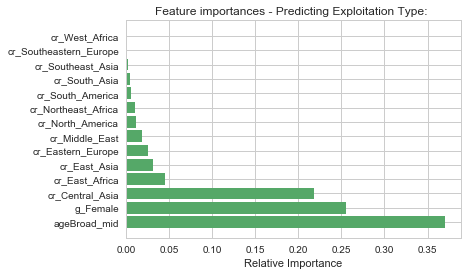

Classes: 
['Forced Labour' 'Forced Marriage' 'Other Exploit' 'Sex and Labour'
 'Sexual Exploit']
Average Probabilities by gender: 
        pp_ForcedLabor  pp_ForcedMarriage  pp_OtherExploit  pp_SexAndLabour  \
gender                                                                        
Female        0.173515           0.003972         0.037996         0.001604   
Male          0.965785           0.000000         0.010401         0.000000   

        pp_SexualExploit  
gender                    
Female          0.782924  
Male            0.023810  
Average Probabilites by majorityStatus: 
                pp_ForcedLabor  pp_ForcedMarriage  pp_OtherExploit  \
majorityStatus                                                       
Adult                 0.394142           0.002977         0.027684   
Minor                 0.261358           0.003161         0.043658   

                pp_SexAndLabour  pp_SexualExploit  
majorityStatus                                     
Adult             

In [112]:
demo_exptype_headers = ['ageBroad_mid', 'g_Female',  
                          'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                          'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                          'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa',
                          'ExploitType']

### Train Test Split - Out put col index -1 
X = demo_exptype_calc[demo_exptype_headers[:-1]]
y = demo_exptype_calc[demo_exptype_headers[-1]]
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7)


model = RandomForestClassifier(n_estimators=500)
model.fit(train_x, train_y)

print "Random Forest Train Accuracy :: ", metrics.accuracy_score(train_y, model.predict(train_x))
print "Random Forest Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, model.predict(test_x))

print ("Cross validating...")
print ("Random Forest - train accuracy: ")
print (np.mean(cross_val_score(model, train_x, train_y.values, scoring='accuracy', cv=10)))

print ("X: ")
print (X.columns)

#Feature Importances - Break down weights of each feature
print ("Feature Importance: ")
importances = model.feature_importances_.round(3)
print (importances)

## Graphing Feature Importances
std = np.std([importances],axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances - Predicting Exploitation Type: ")
plt.barh(range(X.shape[1]), importances[indices],
   color="g", yerr=std[indices], align="center")
plt.yticks(range(X.shape[1]),demo_exptype_headers[:-1])
plt.xlabel('Relative Importance')
plt.show()

print ("Classes: ")
print (model.classes_)

# Predict Probabilities
#pp = model.predict_proba(X)    
cols = ['pp_ForcedLabor', 'pp_ForcedMarriage', 'pp_OtherExploit', 'pp_SexAndLabour', 'pp_SexualExploit']    
df_pp = pd.DataFrame(model.predict_proba(X).round(4),columns=cols)
df_data_pp = GD_data_final.join(df_pp)
#df_pp.head()

# GROUP BYs different demographics
print ("Average Probabilities by gender: ")
print (df_data_pp[['gender','pp_ForcedLabor', 'pp_ForcedMarriage', 'pp_OtherExploit', 'pp_SexAndLabour', 'pp_SexualExploit']].groupby('gender').mean())

print ("Average Probabilites by majorityStatus: ")
print (df_data_pp[['majorityStatus','pp_ForcedLabor', 'pp_ForcedMarriage', 'pp_OtherExploit', 'pp_SexAndLabour', 'pp_SexualExploit']].groupby('majorityStatus').mean())

print ("Average Probabilites by ageBroad_mid: ")
print (df_data_pp[['ageBroad_mid','pp_ForcedLabor', 'pp_ForcedMarriage', 'pp_OtherExploit', 'pp_SexAndLabour', 'pp_SexualExploit']].groupby('ageBroad_mid').mean())

print ("Average Probabilites by citizenshipRegion: ")
print (df_data_pp[['citizenshipRegion','pp_ForcedLabor', 'pp_ForcedMarriage', 'pp_OtherExploit', 'pp_SexAndLabour', 'pp_SexualExploit']].groupby('citizenshipRegion').mean())


### c) Predicting Means of Control based on Demographic and Recruiter Relations

#### i) One-Vs-Rest Classifier

In [115]:
from sklearn.multiclass import OneVsRestClassifier

In [116]:
# Read Demographic vs Means of Control Data
demo_moc_calc = pd.read_csv('assets/demo_moc_calc.csv')

In [118]:
# Carve out Just Recruiter Relation data
rr_handCalc = GD_data_final[['rrIntimatePartner','rrFriend','rrFamily','rrOther','rrUnknown']]

In [120]:
## JOIN Demographics, Means of Control, and Recruiter Relation data
demo_rr_moc_calc = demo_moc_calc.join(rr_handCalc)

In [121]:
demo_rr_moc_headers = ['ms_Adult', 'g_Female','ageBroad_mid',
                          'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                          'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                          'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa', 
                          'cg_Africa', 'cg_Asia', 'cg_Europe', 'cg_Middle_East', 'cg_North_America', 'cg_South_America', 
                            'rrIntimatePartner', 'rrFriend', 'rrFamily', 'rrOther', 
                            'mocDebtBondage', 'mocTakesEarnings',
                           'mocRestrictsFinancialAccess', 'mocThreats', 'mocPsychologicalAbuse',
                           'mocPhysicalAbuse', 'mocSexualAbuse', 'mocFalsePromises',
                           'mocPsychoactiveSubstances', 'mocRestrictsMovement',
                           'mocRestrictsMedicalCare', 'mocExcessiveWorkingHours',
                           'mocUsesChildren', 'mocThreatOfLawEnforcement',
                           'mocWithholdsNecessities', 'mocWithholdsDocuments', 'mocOther',
                           'mocNotSpecified']

### Train Test Split - Out put col index -1 
X = demo_rr_moc_calc[demo_rr_moc_headers[:-18]]
y = demo_rr_moc_calc[demo_rr_moc_headers[-18:-1]]
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7)

# Train OneVsRestClassifier model
ovr = OneVsRestClassifier(LogisticRegression(C=10))
ovr.fit(train_x, train_y)

print "OneVsRestClassifier Train Accuracy :: ", metrics.accuracy_score(train_y, ovr.predict(train_x))
print "OneVsRestClassifier Test Accuracy :: ", metrics.accuracy_score(test_y, ovr.predict(test_x))

## Cross validation only works for Accuracy and not the other measures because it's for multilabeling
print ("Cross validating...")
print ("One-Vs-Rest - train accuracy: ")
print (np.mean(cross_val_score(ovr, train_x, train_y.values, scoring='accuracy', cv=10)))
print ("One-Vs-Rest - train precision: ")

OneVsRestClassifier Train Accuracy ::  0.626990261246
OneVsRestClassifier Test Accuracy ::  0.635593220339
Cross validating...
One-Vs-Rest - train accuracy: 
0.627455470008
One-Vs-Rest - train precision: 


Not that great of a model - probably because of bad data in Recruiter Relations as well as Meals of Control

#### ii) Random Forest Classifier

Random Forest Train Accuracy ::  0.622893801206
Random Forest Logistic regression Test Accuracy ::  0.616660656329
Cross validating...
Random Forest - train accuracy: 
0.614392860857
X: 
Index([u'ageBroad_mid', u'g_Female', u'cr_Central_Asia', u'cr_East_Africa',
       u'cr_East_Asia', u'cr_Eastern_Europe', u'cr_Middle_East',
       u'cr_North_America', u'cr_Northeast_Africa', u'cr_South_America',
       u'cr_South_Asia', u'cr_Southeast_Asia', u'cr_Southeastern_Europe',
       u'cr_West_Africa', u'rrIntimatePartner', u'rrFriend', u'rrFamily'],
      dtype='object')
Feature Importance: 
[ 0.269  0.115  0.083  0.008  0.006  0.088  0.004  0.039  0.009  0.001
  0.04   0.096  0.01   0.009  0.122  0.039  0.063]


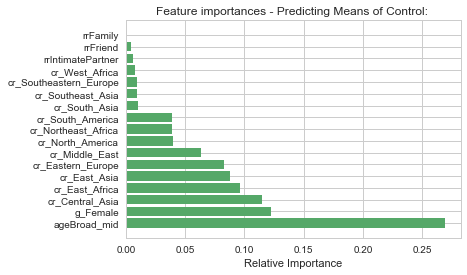

In [123]:
demo_rr_moc_headers = ['ageBroad_mid','g_Female',
                          'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                          'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                          'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa', 
                            'rrIntimatePartner', 'rrFriend', 'rrFamily', 
                            'mocDebtBondage', 'mocTakesEarnings',
                           'mocRestrictsFinancialAccess', 'mocThreats', 'mocPsychologicalAbuse',
                           'mocPhysicalAbuse', 'mocSexualAbuse', 'mocFalsePromises',
                           'mocPsychoactiveSubstances', 'mocRestrictsMovement',
                           'mocRestrictsMedicalCare', 'mocExcessiveWorkingHours',
                           'mocUsesChildren', 'mocThreatOfLawEnforcement',
                           'mocWithholdsNecessities', 'mocWithholdsDocuments', 'mocOther']

### Train Test Split - Out put col index -1 
X = demo_rr_moc_calc[demo_rr_moc_headers[:-17]]
y = demo_rr_moc_calc[demo_rr_moc_headers[-17:-1]]
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7)

model = RandomForestClassifier(n_estimators=10)
model.fit(train_x, train_y)

print "Random Forest Train Accuracy :: ", metrics.accuracy_score(train_y, model.predict(train_x))
print "Random Forest Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, model.predict(test_x))

print ("Cross validating...")
print ("Random Forest - train accuracy: ")
print (np.mean(cross_val_score(model, train_x, train_y.values, scoring='accuracy', cv=10)))

print ("X: ")
print (X.columns)

#Feature Importances - Break down weights of each feature
print ("Feature Importance: ")
importances = model.feature_importances_.round(3)
print (importances)

## Graphing Feature Importances
std = np.std([importances],axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances - Predicting Means of Control: ")
plt.barh(range(X.shape[1]), importances[indices],
   color="g", yerr=std[indices], align="center")
plt.yticks(range(X.shape[1]), demo_rr_moc_headers[:-17])
plt.xlabel('Relative Importance')
plt.show()

### d) Predicting Type of Labor based on Demographics and Recruiter Relationship

In [125]:
# Read Demographic vs Labor Type Data - Only for isForcedLabour == 1
demo_labortype_calc = pd.read_csv('assets/demo_labortype_calc.csv')
demo_labortype_calc.reset_index(drop=True)
# Carve out Just Recruiter Relation data
GD_data_Labor = GD_data_final[GD_data_final['isForcedLabour']==1].reset_index(drop=True)
rr_Labor_handCalc = GD_data_Labor[['rrIntimatePartner','rrFriend','rrFamily','rrOther','rrUnknown']]
rr_Labor_handCalc.reset_index(drop=True)
rr_test = rr_Labor_handCalc
## JOIN Demographics, Means of Control, and Recruiter Relation data
#demo_rr_labortype_calc = demo_labortype_calc.join(rr_Labor_handCalc)
demo_rr_Labortype_calc = pd.concat([demo_labortype_calc,rr_test],axis=1)

### Consolidate all types of labor into one column

def combine_laborType(x):
    if x['tolAgriculture'] == 1:
        return 'Agriculture'
    elif x['tolAquafarming'] == 1:
        return 'Aquafarming'
    elif x['tolBegging'] == 1:
        return 'Begging'
    elif x['tolConstruction'] == 1:
        return 'Construction'
    elif x['tolDomesticWork'] == 1:
        return 'DomesticWork'
    elif x['tolHospitality'] == 1:
        return 'Hospitality'
    elif x['tolIllicitActivities'] == 1:
        return 'IllicitActivities'
    elif x['tolManufacturing'] == 1:
        return 'Manufacturing'
    elif x['tolMiningOrDrilling'] == 1:
        return 'MiningOrDrilling'
    elif x['tolPeddling'] == 1:
        return 'Peddling'
    elif x['tolTransportation'] == 1:
        return 'Transportation'
    elif x['tolOther'] == 1:
        return 'Other'
    elif x['tolNotSpecified'] == 1:
        return 'NotSpecified'
    else:
        return 0   
demo_rr_Labortype_calc['LaborType'] = demo_rr_Labortype_calc.apply(combine_laborType,axis=1)

In [128]:
headers = ['ageBroad_mid','g_Female', 
                          'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                          'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                          'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa', 
                            'rrIntimatePartner', 'rrFriend', 'rrFamily', 'rrOther', 
                             'LaborType']

### Train Test Split - Out put col index -1 
X = demo_rr_Labortype_calc[headers[:-1]]
y = demo_rr_Labortype_calc[headers[-1]]
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7)

# Train multinomial logistic regression model
mul_lr = LogisticRegression(C=10,multi_class='multinomial', solver='newton-cg')
mul_lr.fit(train_x, train_y)


print "Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(train_y, mul_lr.predict(train_x))
print "Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, mul_lr.predict(test_x))

print ("Cross validating...")

print ("Multinomial Log Reg - train accuracy: ")
print (np.mean(cross_val_score(mul_lr, train_x, train_y.values, scoring='accuracy', cv=10)))

#region_unit = np.identity(12)
#TEST  AGE-GENDER COMBO:
ag = np.array([[10,1],[10,0],[22,1],[22,0],[40,1],[40,0]])

print ("Classes: ")
print (mul_lr.classes_)
pred_y = mul_lr.predict(test_x)

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

## to use, first generate confusion matrix:
print ("Confusion Matrix: ")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, pred_y)
target = ['Agriculture', 'Aquafarming', 'Begging', 'Construction', 'DomesticWork',
'Hospitality', 'Manufacturing', 'NotSpecified', 'Other', 'Peddling']
## then convert to pandas DataFrame:
cm_as_df4=cm2df(cm,target)
print (cm_as_df4)


Multinomial Logistic regression Train Accuracy ::  0.764867724868
Multinomial Logistic regression Test Accuracy ::  0.74962962963
Cross validating...
Multinomial Log Reg - train accuracy: 


C:\Users\ellei\Anaconda2\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


0.766551892891
Classes: 
['Agriculture' 'Aquafarming' 'Begging' 'Construction' 'DomesticWork'
 'Hospitality' 'Manufacturing' 'NotSpecified' 'Other' 'Peddling']
Confusion Matrix: 
               Agriculture  Aquafarming  Begging  Construction  DomesticWork  \
Agriculture             11            0        0             0             0   
Aquafarming              0            8        0             0             0   
Begging                  0            0       18             0             0   
Construction             0            0        0           207             0   
DomesticWork             0            0        0             0            49   
Hospitality              0            0        0             0             0   
Manufacturing            2            0        0            36             0   
NotSpecified             5           14        0            95            20   
Other                    2            0        0             0             1   
Peddling             

 | Recall	| Precision
 --- | --- | ---
Agriculture	| 12%	| 53%
Aquafarming	| 0%	| 0%
Begging	| 51%	| 100%
Construction |	67% |	61%
DomesticWork	| 32%	| 60%
Hospitality	| 0%	| N/A
Manufacturing	| 59%	| 69%
Other	| 6% |	67%
Peddling	| 38%	| 100%

##### Interpretation:
- Begging, Construction, Manufacturing has moderate-high recall and precision

#### ii) Random Forest Classfier

Random Forest Train Accuracy ::  0.838306878307
Random Forest Logistic regression Test Accuracy ::  0.832098765432
Cross validating...
Random Forest - train accuracy: 
0.830673278606
X: 
Index([u'ageBroad_mid', u'g_Female', u'cr_Central_Asia', u'cr_East_Africa',
       u'cr_East_Asia', u'cr_Eastern_Europe', u'cr_Middle_East',
       u'cr_North_America', u'cr_Northeast_Africa', u'cr_South_America',
       u'cr_South_Asia', u'cr_Southeast_Asia', u'cr_Southeastern_Europe',
       u'cr_West_Africa', u'rrIntimatePartner', u'rrFriend', u'rrFamily',
       u'rrOther'],
      dtype='object')
Feature Importance: 
[ 0.152  0.107  0.056  0.034  0.     0.149  0.013  0.054  0.     0.     0.021
  0.126  0.     0.018  0.003  0.013  0.02   0.235]


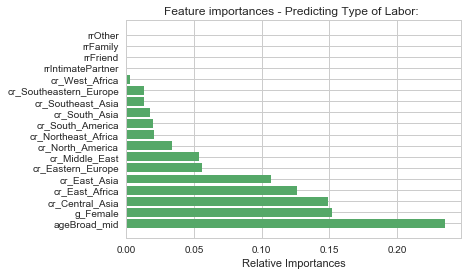

Classes: 
['Agriculture' 'Aquafarming' 'Begging' 'Construction' 'DomesticWork'
 'Hospitality' 'Manufacturing' 'NotSpecified' 'Other' 'Peddling']
Average Probabilities by gender: 
        pp_Agriculture  pp_Aquafarming  pp_Begging  pp_Construction  \
gender                                                                
Female        0.035151        0.000033    0.026572         0.005711   
Male          0.030196        0.020977    0.020591         0.242794   

        pp_DomesticWork  pp_Hospitality  pp_Manufacturing  pp_NotSpecified  \
gender                                                                       
Female         0.136025        0.000000          0.071756         0.688316   
Male           0.011670        0.002868          0.025768         0.619733   

        pp_Other  pp_Peddling  
gender                         
Female  0.036430     0.000005  
Male    0.019567     0.005855  
Average Probabilites by majorityStatus: 
                pp_Agriculture  pp_Aquafarming  pp_Beg

In [130]:
headers = ['ageBroad_mid','g_Female', 
                          'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                          'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                          'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa',    
                            'rrIntimatePartner', 'rrFriend', 'rrFamily', 'rrOther', 
                             'LaborType']

### Train Test Split - Out put col index -1 
X = demo_rr_Labortype_calc[headers[:-1]]
y = demo_rr_Labortype_calc[headers[-1]]
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7)

model = RandomForestClassifier(n_estimators=500)
model.fit(train_x, train_y)

print "Random Forest Train Accuracy :: ", metrics.accuracy_score(train_y, model.predict(train_x))
print "Random Forest Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, model.predict(test_x))

print ("Cross validating...")
print ("Random Forest - train accuracy: ")
print (np.mean(cross_val_score(model, train_x, train_y.values, scoring='accuracy', cv=10)))

print ("X: ")
print (X.columns)

#Feature Importances - Break down weights of each feature
print ("Feature Importance: ")
importances = model.feature_importances_.round(3)
print (importances)

## Graphing Feature Importances
std = np.std([importances],axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances - Predicting Type of Labor: ")
plt.barh(range(X.shape[1]), importances[indices],
   color="g", yerr=std[indices], align="center")
plt.yticks(range(X.shape[1]), headers[:-1])
plt.xlabel('Relative Importances')
plt.show()

print ("Classes: ")
print (model.classes_)


# Predict Probabilities
#pp = model.predict_proba(X)    
cols = ['pp_Agriculture', 'pp_Aquafarming', 'pp_Begging', 'pp_Construction', 'pp_DomesticWork', 'pp_Hospitality', 
        'pp_Manufacturing', 'pp_NotSpecified', 'pp_Other', 'pp_Peddling']    
df_pp = pd.DataFrame(model.predict_proba(X).round(4),columns=cols)
df_data_pp = GD_data_Labor.join(df_pp)
#df_pp.head()


# GROUP BYs different demographics
print ("Average Probabilities by gender: ")
print (df_data_pp[['gender','pp_Agriculture', 'pp_Aquafarming', 'pp_Begging', 'pp_Construction', 'pp_DomesticWork', 'pp_Hospitality', 
        'pp_Manufacturing', 'pp_NotSpecified', 'pp_Other', 'pp_Peddling']].groupby('gender').mean())

print ("Average Probabilites by majorityStatus: ")
print (df_data_pp[['majorityStatus','pp_Agriculture', 'pp_Aquafarming', 'pp_Begging', 'pp_Construction', 'pp_DomesticWork', 'pp_Hospitality', 
        'pp_Manufacturing', 'pp_NotSpecified', 'pp_Other', 'pp_Peddling']].groupby('majorityStatus').mean())

print ("Average Probabilites by ageBroad_mid: ")
print (df_data_pp[['ageBroad_mid','pp_Agriculture', 'pp_Aquafarming', 'pp_Begging', 'pp_Construction', 'pp_DomesticWork', 'pp_Hospitality', 
        'pp_Manufacturing', 'pp_NotSpecified', 'pp_Other', 'pp_Peddling']].groupby('ageBroad_mid').mean())

print ("Average Probabilites by citizenshipRegion: ")
print (df_data_pp[['citizenshipRegion','pp_Agriculture', 'pp_Aquafarming', 'pp_Begging', 'pp_Construction', 'pp_DomesticWork', 'pp_Hospitality', 
        'pp_Manufacturing', 'pp_NotSpecified', 'pp_Other', 'pp_Peddling']].groupby('citizenshipRegion').mean())

### 3) Predicting Type of Sex Exploitation

In [133]:
# Read Demographic vs Labor Type Data - Only for isForcedLabour == 1
demo_sexExptype_calc = pd.read_csv('assets/demo_sexExptype_calc.csv')
demo_sexExptype_calc.reset_index(drop=True)
GD_data_Sex = GD_data_final[GD_data_final['isSexualExploit']==1].reset_index(drop=True)
rr_sexType_handCalc = GD_data_Sex[['rrIntimatePartner','rrFriend','rrFamily','rrOther','rrUnknown']]
rr_sexType_handCalc.reset_index(drop=True)
demo_rr_sextype_calc = pd.concat([demo_sexExptype_calc,rr_sexType_handCalc],axis=1)
def combine_sexExpType(x):
    if x['tosProstitution'] == 1:
        return 'Prostitution'
    elif x['tosPornography'] == 1:
        return 'Pornography'
    elif x['tosRemoteInteractiveServices'] == 1:
        return 'RemoteInteractiveServices'
    elif x['tosPrivateSexualServices'] == 1:
        return 'PrivateSexualServices'
    elif x['tosNotSpecified'] == 1:
        return 'NotSpecified'
    else:
        return 0
    
demo_rr_sextype_calc['SexExpType'] = demo_rr_sextype_calc.apply(combine_sexExpType,axis=1)


#### i) Multinomial Logistic Regression

In [137]:
headers = ['ageBroad_mid','g_Female',
                          'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                          'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                          'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa',
                            'rrIntimatePartner', 'rrFriend', 'rrFamily', 'rrOther', 
                             'SexExpType']

### Train Test Split - Out put col index -1 
X = demo_rr_sextype_calc[headers[:-1]]
y = demo_rr_sextype_calc[headers[-1]]
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7)

# Train multinomial logistic regression model
mul_lr = LogisticRegression(C=10,multi_class='multinomial', solver='newton-cg')
mul_lr.fit(train_x, train_y)

print "Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(train_y, mul_lr.predict(train_x))
print "Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, mul_lr.predict(test_x))

print ("Cross validating...")
print ("Multinomial Log Reg - train accuracy: ")
print (np.mean(cross_val_score(mul_lr, train_x, train_y.values, scoring='accuracy', cv=10)))

print ("Classes: ")
print (mul_lr.classes_)
pred_y = mul_lr.predict(test_x)

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

## to use, first generate confusion matrix:
print ("Confusion Matrix: ")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, pred_y)
target = ['NotSpecified', 'Pornography', 'PrivateSexualServices', 'Prostitution']
## then convert to pandas DataFrame:
cm_as_df5=cm2df(cm,target)
#cm_as_df5.to_csv('cm_as_df5.csv',index=True)
cm_as_df5

Multinomial Logistic regression Train Accuracy ::  0.686000256641
Multinomial Logistic regression Test Accuracy ::  0.699790481892
Cross validating...
Multinomial Log Reg - train accuracy: 
0.67906072442
Classes: 
['NotSpecified' 'Pornography' 'PrivateSexualServices' 'Prostitution']
Confusion Matrix: 


,NotSpecified,Pornography,PrivateSexualServices,Prostitution
NotSpecified,1385,0,0,638
Pornography,0,0,0,10
PrivateSexualServices,0,0,0,3
Prostitution,352,0,0,953


##### Interpretations:
 | Recall | Precision
--- | --- | ---
NotSpecified	| 77%	| 74%
Pornography	| 0%	| N/A
PrivateSexualServices	| 0%	| N/A
Prostitution	| 57%	| 61%

Missing data is once again an issue. These results are not really reliable.

#### ii) Random Forest Classifier

Random Forest Train Accuracy ::  0.706788143205
Random Forest Logistic regression Test Accuracy ::  0.693804250224
Cross validating...
Random Forest - train accuracy: 
0.695996572272
X: 
Index([u'ageBroad_mid', u'g_Female', u'cr_Central_Asia', u'cr_East_Africa',
       u'cr_East_Asia', u'cr_Eastern_Europe', u'cr_Middle_East',
       u'cr_North_America', u'cr_Northeast_Africa', u'cr_South_America',
       u'cr_South_Asia', u'cr_Southeast_Asia', u'cr_Southeastern_Europe',
       u'cr_West_Africa', u'rrIntimatePartner', u'rrFriend', u'rrFamily'],
      dtype='object')
Feature Importance: 
[ 0.18   0.009  0.005  0.     0.036  0.44   0.     0.075  0.     0.012  0.
  0.     0.135  0.032  0.03   0.033  0.013]


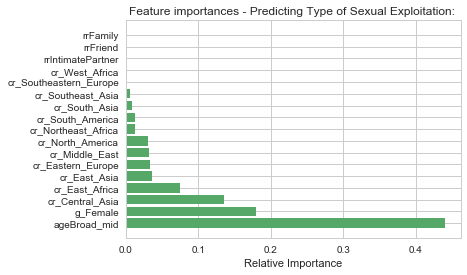

Classes: 
['NotSpecified' 'Pornography' 'PrivateSexualServices' 'Prostitution']
Average Probabilities by gender: 
        pp_NotSpecified  pp_Pornography  pp_PrivateSexualServices  \
gender                                                              
Female         0.609265        0.004106                  0.001039   
Male           0.635661        0.000317                  0.000483   

        pp_Prostitution  
gender                   
Female         0.385610  
Male           0.363542  
Average Probabilites by majorityStatus: 
                pp_NotSpecified  pp_Pornography  pp_PrivateSexualServices  \
majorityStatus                                                              
Adult                  0.674513        0.001904                  0.001405   
Minor                  0.428754        0.010097                  0.000000   

                pp_Prostitution  
majorityStatus                   
Adult                  0.322195  
Minor                  0.561172  
Average Probabilite

In [139]:
headers = ['ageBroad_mid','g_Female', 
                          'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                          'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                          'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa',    
                            'rrIntimatePartner', 'rrFriend', 'rrFamily', 
                             'SexExpType']

### Train Test Split - Out put col index -1 
X = demo_rr_sextype_calc[headers[:-1]]
y = demo_rr_sextype_calc[headers[-1]]
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7)

model = RandomForestClassifier(n_estimators=500)
model.fit(train_x, train_y)

print "Random Forest Train Accuracy :: ", metrics.accuracy_score(train_y, model.predict(train_x))
print "Random Forest Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, model.predict(test_x))

print ("Cross validating...")
print ("Random Forest - train accuracy: ")
print (np.mean(cross_val_score(model, train_x, train_y.values, scoring='accuracy', cv=10)))

print ("X: ")
print (X.columns)

#Feature Importances - Break down weights of each feature
print ("Feature Importance: ")
importances = model.feature_importances_.round(3)
print (importances)



## Graphing Feature Importances
std = np.std([importances],axis=0)
indices = np.argsort(importances)[::-1]
#features = demo_rr_sextype_calc['feature_names']
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances - Predicting Type of Sexual Exploitation: ")
plt.barh(range(X.shape[1]), importances[indices],
   color="g", yerr=std[indices], align="center")
plt.yticks(range(X.shape[1]),headers[:-1])
plt.xlabel('Relative Importance')
plt.show()

print ("Classes: ")
print (model.classes_)


# Predict Probabilities
#pp = model.predict_proba(X)    
cols = ['pp_NotSpecified', 'pp_Pornography', 'pp_PrivateSexualServices', 'pp_Prostitution']    
df_pp = pd.DataFrame(model.predict_proba(X).round(4),columns=cols)
df_data_pp = GD_data_Sex.join(df_pp)
#df_pp.head()

# GROUP BYs different demographics
print ("Average Probabilities by gender: ")
print (df_data_pp[['gender','pp_NotSpecified', 'pp_Pornography', 'pp_PrivateSexualServices', 'pp_Prostitution']].groupby('gender').mean())

print ("Average Probabilites by majorityStatus: ")
print (df_data_pp[['majorityStatus','pp_NotSpecified', 'pp_Pornography', 'pp_PrivateSexualServices', 'pp_Prostitution']].groupby('majorityStatus').mean())

print ("Average Probabilites by ageBroad_mid: ")
print (df_data_pp[['ageBroad_mid','pp_NotSpecified', 'pp_Pornography', 'pp_PrivateSexualServices', 'pp_Prostitution']].groupby('ageBroad_mid').mean())

print ("Average Probabilites by citizenshipRegion: ")
print (df_data_pp[['citizenshipRegion','pp_NotSpecified', 'pp_Pornography', 'pp_PrivateSexualServices', 'pp_Prostitution']].groupby('citizenshipRegion').mean())
